<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты" data-toc-modified-id="Импорты-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Токенизация" data-toc-modified-id="Токенизация-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Токенизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорты

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import torch

from nltk import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TextClassificationPipeline
from wordcloud import WordCloud

### Предобработка

In [2]:
df = pd.read_csv('toxic_comments.csv', index_col=0)

In [3]:
df.sample(10)

,text,toxic
90810,{{unblock}}\n1. There is no practical way in t...,0
43556,Sources in Portuguese\nSee: http://www.konisto...,0
86022,Or you could let the community deal with it wi...,0
79998,"""""""Don't Count on It""""\n\nGiven what has happe...",0
54895,Probably had to do with it being a Phillip Def...,0
59190,"""\n\nSome of this discussion seems to have got...",0
6586,I've not got a Mac.,0
65495,PLease Read the SOurces and come to relevant a...,0
81364,2007 (UTC)\n\nMaybe you should go boil your he...,0
47389,"""\n Then my response to you is the same as it ...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Посмотрим, что там с длинной текста на гистограмме.

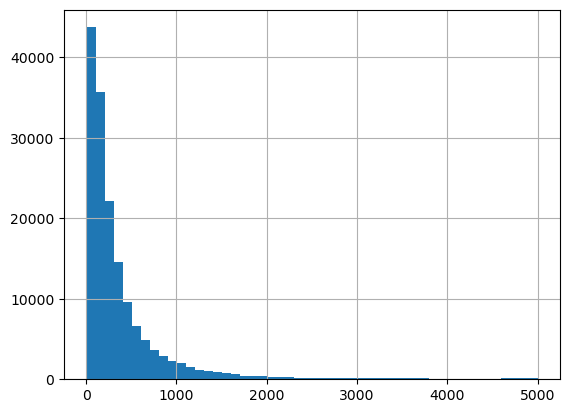

In [5]:
df['text'].str.len().hist(bins=50);

5000 знаков - это слишком много. Хотел сначала делать ограничение, но в процессе анализа понял, что лучше оставить как есть.

Посмотрим на баланс классов.

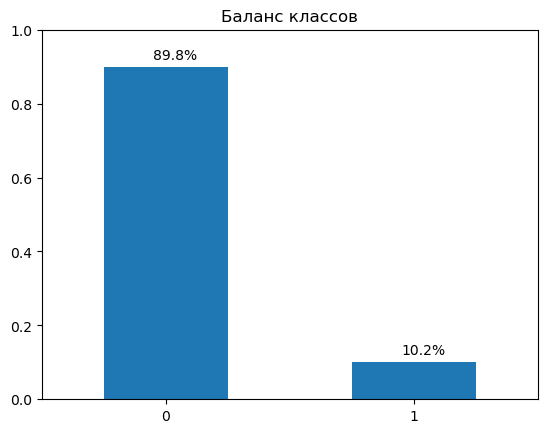

In [6]:
df['toxic'].value_counts(normalize=True).plot(kind='bar', rot=0, title='Баланс классов', ylim=(0, 1))
for y, x in zip(df['toxic'].value_counts(normalize=True), (0, 1)):
    plt.text(x - 0.05, y + 0.02, f'{y:.1%}')

Токсичных коммеантриев всего 10 %. Нужно это учитывать при построении модели.

### Лемматизация

In [7]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

Функция для лемматизации:
- Разбиваем на слова с помощью nltk. Здесь хорошо отсеиваются спецсимволы конца строки и подобные.
- Лемматизируем каждое оставшееся слово. Объединяем в предложения.
- Оставляем только слова с маленькой буквы в этой строке

In [8]:
def lemmatize(text):
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])
    
    return text

In [9]:
tqdm.pandas(desc="progress")

df['lem_text'] = df['text'].progress_apply(lemmatize)

progress: 100%|████████████████████████████████████████████████████████████████| 159292/159292 [35:45<00:00, 74.23it/s]


In [10]:
df['lem_text'].isna().sum()

0

Ничто в ноль не сократилось, и это хорошо.

In [11]:
df

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation edit username Hardcore Metallica F...
1,D'aww! He matches this background colour I'm s...,0,match background colour seemingly stick thank ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,second time ask view completely contradict cov...
159447,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing talk page
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm s actual article prostitution ring...
159449,And it looks like it was actually you who put ...,0,look like actually speedy version delete look


Хорошие результаты при лемматизации

In [16]:
df.to_csv('tweet_lemm.csv', index=False)

In [17]:
data = pd.read_csv('tweet_lemm.csv')

In [18]:
data

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation edit username Hardcore Metallica F...
1,D'aww! He matches this background colour I'm s...,0,match background colour seemingly stick thank ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,second time ask view completely contradict cov...
159288,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing talk page
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm s actual article prostitution ring...
159290,And it looks like it was actually you who put ...,0,look like actually speedy version delete look


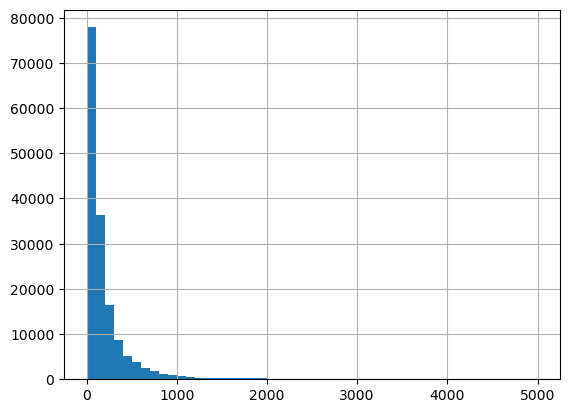

In [29]:
df['lem_text'].str.len().hist(bins=50);

In [30]:
df = df[df['lem_text'].str.len() < 1000]

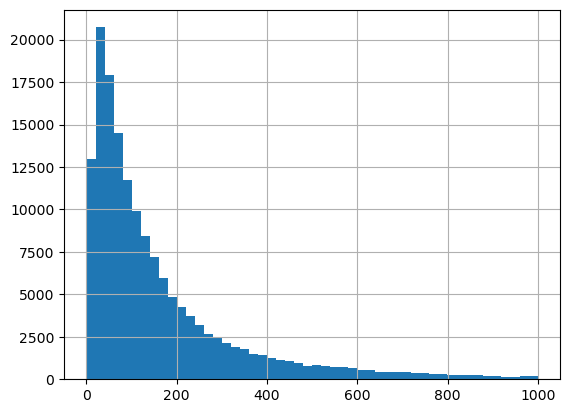

In [31]:
df['lem_text'].str.len().hist(bins=50);

Посмотрим на частоту распределения слов.

Чтобы быстрее работала возьмем выборку в 5000 объектов у обоих классов.

In [32]:
not_toxic_words = ' '.join([text for text in df[df['toxic'] == 0].sample(5000)['lem_text']])
toxic_words = ' '.join([text for text in df[df['toxic'] == 1].sample(5000)['lem_text']])

In [33]:
not_toxic_text = nltk.Text(word_tokenize(not_toxic_words))
toxic_text = nltk.Text(word_tokenize(toxic_words))

In [34]:
not_toxic_fdist = FreqDist(not_toxic_text)
toxic_fdist = FreqDist(toxic_text)

In [35]:
w = pd.concat(
    [
        pd.DataFrame(toxic_fdist.most_common(20), columns =['word', 'frec']), 
        pd.DataFrame(not_toxic_fdist.most_common(20), columns =['word', 'frec'])
    ],
    axis=1,
    keys=['toxic', 'not_toxic']
)

In [36]:
w

toxic        not_toxic      
         word  frec       word  frec
0        fuck  1117    article  2104
1        like   895       page  1630
2        page   761       edit  1066
3        know   696       talk  1014
4           u   677  Wikipedia  1011
5        edit   617       like   796
6     article   555      think   745
7       block   499     source   713
8      people   494      thank   687
9     fucking   480       know   680
10       shit   476        add   583
11       stop   446       need   489
12  Wikipedia   439        use   479
13      think   430       time   458
14       talk   403       look   446
15        gay   400       link   442
16       want   395       want   441
17       suck   376       good   441
18         go   376     remove   435
19       time   341     people   423

Можно заметить, что в обоих классах часто повторяются одни и те же слова. Выделим их, и добавим потом к стоп словам tf-idf

In [37]:
stop_words = []
for word in w['toxic']['word']:
    if word in w['not_toxic']['word'].values:
        stop_words.append(word)
        
stop_words

['like',
 'page',
 'know',
 'edit',
 'article',
 'people',
 'Wikipedia',
 'think',
 'talk',
 'want',
 'time']

Посмотрим на облако распределения.

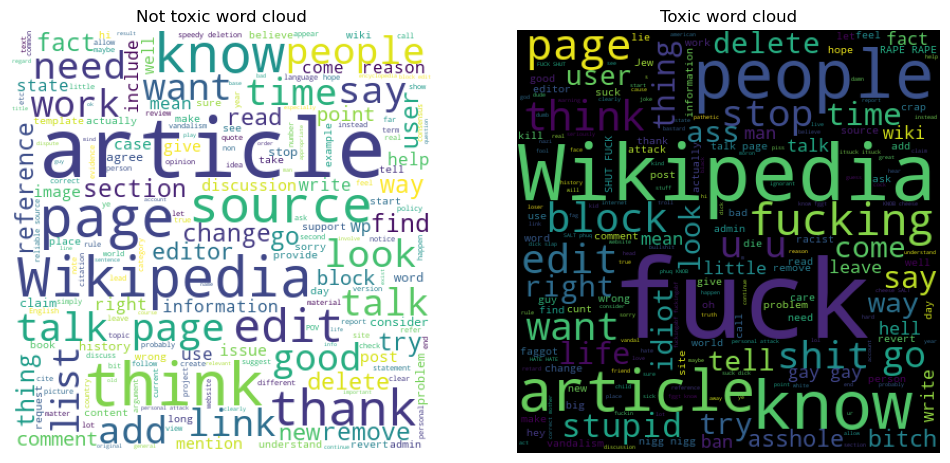

In [38]:
wordcloud_1 = WordCloud(height=400, background_color='white').generate(not_toxic_words)
wordcloud_2 = WordCloud(height=400, background_color='black').generate(toxic_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(wordcloud_1)
ax1.axis('off')
ax1.set_title('Not toxic word cloud')
ax2.imshow(wordcloud_2)
ax2.axis('off')
ax2.set_title('Toxic word cloud')
plt.show()

Кроме всего прочего можно увидеть встречающееся и там и там слово 'wikipedia'. Тоже добавлю его к стоп словам.

In [39]:
stop_words.append('wikipedia')

In [40]:
stop_words

['like',
 'page',
 'know',
 'edit',
 'article',
 'people',
 'Wikipedia',
 'think',
 'talk',
 'want',
 'time',
 'wikipedia']

## Обучение

Разделим сначала на тестовую и обучающие выборки с учетом распределения классов.

In [41]:
train, test = train_test_split(df, test_size=0.2, random_state=123, stratify=df['toxic'])

In [42]:
test['toxic'].value_counts(normalize=True)

0    0.897684
1    0.102316
Name: toxic, dtype: float64

In [43]:
X_train = train['lem_text']
X_test = test['lem_text']
y_train = train['toxic']
y_test = test['toxic']

Выделим стоп слова из `TfidfVectorizer` и дополним своими словами.

In [44]:
tf = TfidfVectorizer(stop_words='english')
stop_words.extend(list(tf.get_stop_words()))

Функция для тестирования классификаторов с пайплайном

In [ ]:
pipe = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LogisticRegression(n_jobs=-1, random_state=12345, class_weight='balanced', solver='liblinear'),
        ]
    )


parameter_grid = {
        "vect__ngram_range": ((1, 1), (1, 2)),
        "vect__norm": ("l1", "l2"),
        "clf__C": [10.0, 1.0]
    }

grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=parameter_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

In [45]:
def benchmark(clf, name, X_train=X_train, y_train=y_train):
    print('_' * 80)
    print("Training: ")
    print(clf)
    
    pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer(stop_words=stop_words)),
            ("clf", clf),
        ]
    )
    
    parameter_grid = {
        # "vect__max_df": (0.5, 1.0),
        "vect__ngram_range": ((1, 1), (1, 2)),
        "vect__norm": ("l1", "l2"),
    }
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=parameter_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=1,
    )
    
    grid_search.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results[cv_results['rank_test_score'] == 1].iloc[0]
    
    score = grid_search.best_score_
    train_time = cv_results['mean_fit_time']
    test_time = cv_results['mean_score_time']

    print(f"train time: {train_time:0.3f}s")
    print(f"test time:  {test_time:0.3f}s")
    print(f"f1-score:   {score:0.3f}")
    print()

    return name, score, train_time, test_time, grid_search

Набор классификаторов.

In [46]:
def train_result(X=X_train, y=y_train):
    results = []
    best_score = 0
    best_model = ''

    for clf, name in (
        (LogisticRegression(max_iter=1000, n_jobs=-1, random_state=123), "Logistic Regression"),
        (RidgeClassifier(tol=1e-2, solver="auto", random_state=123), "Ridge Classifier"),
        (Perceptron(n_jobs=-1, random_state=123), "Perceptron"),
        (PassiveAggressiveClassifier(n_jobs=-1, random_state=123), "Passive-Aggressive"),
        (LinearSVC(penalty='l1', dual=False, tol=1e-3, random_state=123), "LinearSVC l1"),
        (LinearSVC(penalty='l2', dual=False, tol=1e-3, random_state=123), "LinearSVC l2"),
        (SGDClassifier(alpha=.0001, penalty="elasticnet", random_state=123), "SGD Classifier"),
        (NearestCentroid(), "Rocchio classifier"),
    ):
        print('=' * 80)
        print(name)
        
        res = benchmark(clf, name, X, y)
        if res[2] > best_score:
            best_score = res[2]
            best_model = res[-1]
        
        results.append(res)
        
    return results, best_model

Начинем тест моделей

In [47]:
results, best_model = train_result()

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(max_iter=1000, n_jobs=-1, random_state=123)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
train time: 9.404s
test time:  1.776s
f1-score:   0.716

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(random_state=123, tol=0.01)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
train time: 15.415s
test time:  2.624s
f1-score:   0.744

Perceptron
________________________________________________________________________________
Training: 
Perceptron(n_jobs=-1, random_state=123)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
train time: 11.823s
test time:  2.513s
f1-score:   0.753

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(n_jobs=-1, random_state=123)
Fitting 

Функция для визуализации графиков

In [29]:
def show_result(results):
    
    indices = np.arange(len(results))

    res = [[x[i] for x in results] for i in range(5)]

    clf_names, score, training_time, test_time, model = res
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='r')
    plt.barh(indices + .25, training_time, .2, label="training time", color='g')
    plt.barh(indices + .5, test_time, .2, label="test time", color='black')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.15)

    for i, c in zip(indices, clf_names):
        plt.text(-.2, i - 0.05, c)

    for i, c in zip(indices, score):
        plt.text(c + .01, i - 0.05, round(c, 2))

    plt.grid(linestyle='-', linewidth=.4)
    plt.show()

А теперь посмотрим на графики оценок. Время обучения и предсказания нормированно относительно всех моделей.

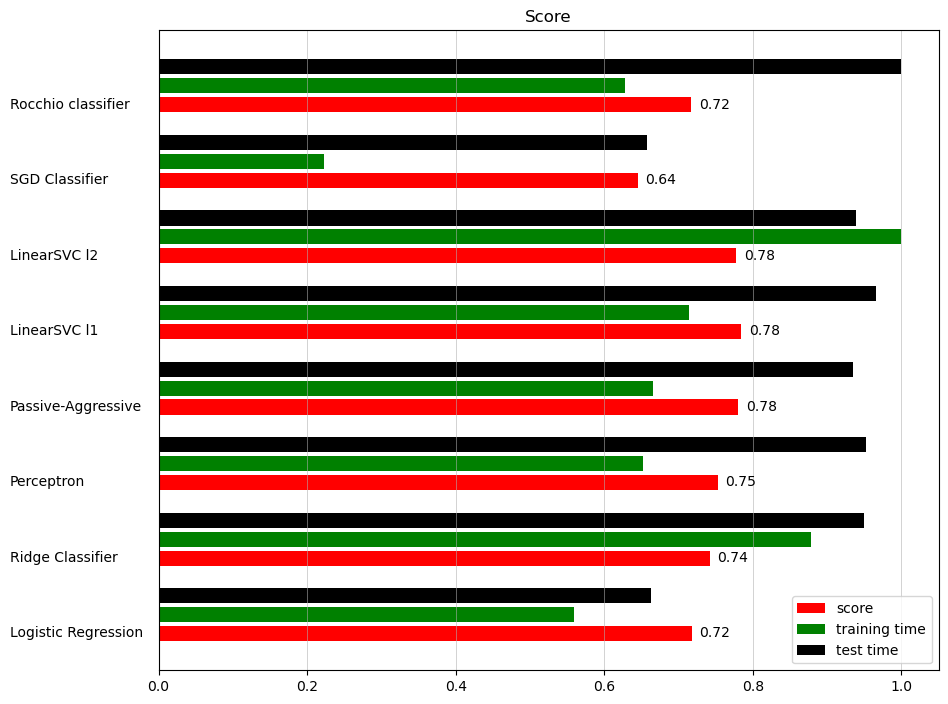

In [30]:
show_result(results)

Посмотрим на лучшую модель и ее параметры

In [31]:
best_model.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['like', 'know', 'page', 'edit',
                                             'article', 'people', 'think',
                                             'talk', 'wikipedia', 'even',
                                             'hereupon', 'me', 'such', 'and',
                                             'two', 'thereby', 'seeming',
                                             'among', 'within', 'ours',
                                             'bottom', 'wherever', 'whence',
                                             'hasnt', 'myself', 'since', 'eg',
                                             'down', 'describe', 'side', ...])),
                ('clf', LinearSVC(dual=False, random_state=123, tol=0.001))])

In [32]:
best_model.best_params_

{'vect__ngram_range': (1, 2), 'vect__norm': 'l2'}

Посмотрим на оценку на тестовой выборке

In [34]:
%%time
print(f'f1-score:   {f1_score(y_test, best_model.predict(X_test)):.3f}')

f1-score:   0.788
CPU times: total: 1.98 s
Wall time: 1.99 s


Прекрасный результат

## BERT

Возьмем подходящую модель с hugging-face сразу для классификации твитов.

In [35]:
model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

Возьмем небольшую выборку с учетом классов, и посмотрим на оценку f1 для предсказаний на этой выборке.

In [36]:
test_bert = test.sample(1000, weights='toxic', random_state=123)

In [37]:
y_pred = []
for text in tqdm(test_bert['text']):
    # print(text)
    pred = pipeline(text[:512])
    y_pred.append(1 if pred[0]['label'] == 'toxic' else 0)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.58it/s]


In [38]:
print(f'f1-score:   {f1_score(test_bert["toxic"], y_pred):.3f}')

f1-score:   0.765


Отличная оценка, особенно с учетом того, что никакой предобработки не требуется, и небольшое количество кода.

## Выводы

Рассмотренны данные классификации токсичности. Текст очищен от мусорных символов, лемматизирован средствами библиотеки Spacy. С помощью Tfidf выделены признаки для обучения моделей.
Рассмотренны несколлько моделей для обучении. Лучший результат показал LinearSVC() с результатом метрики f1 на тесте - 0.789
Расмотрен способ предсказания с помощью обученной нейронной сети. Результат f1 на небольшой выборке - 0.765. Учитывая небольшой вес модели - это приличный результат, не требующий заниматься предобработкой и выделением признаков.